Se presentan las librerias utilizdas, pandas es una libreria de analisis de datos ; Tweet_mx api  desarollada para administrar las querrys y la extracion de tweets tambien sera la clase utilizada para la administracion de la base de datos.

In [5]:
import re
import unicodedata
import pandas as pd
from  Tweet_mx import Tweet_mx
from Base_d import Bd
import csv
import json
import matplotlib.pyplot as plt
import seaborn as sns 
from transformers import pipeline 

import warnings
warnings.filterwarnings(action = 'ignore') 


In [7]:
def clean_accents(text):
    # Eliminar signos de puntuación
    text = re.sub(r'[^\w\s]+', ' ', text)
    # Eliminar emojis
    text = text.encode('ascii', 'ignore').decode('utf-8')
    # Eliminar acentos
    text = unicodedata.normalize('NFKD', text).encode('ASCII', 'ignore').decode('ASCII')
    # Convertir todo el texto a minúsculas
    text = text.lower()
    return text

def clave_valor_maximo(diccionario):
    clave_maxima = max(diccionario, key=diccionario.get)
    valor_maximo = diccionario[clave_maxima]
    return clave_maxima, valor_maximo

def count_words(text):
    exclude_words = ['el',"gan",'si','sus', 'jos','san','mis','fue','zcalo','amrica','leo','este','ha','la', 'no','los', 'las', 'un', 'una', 'unos', 'unas', 'al', 'del', 'lo', 'le', 'y', 'e', 'o', 'u', 'de', 'a', 'en', 'que', 'es', 'por', 'para', 'con', 'se', 'su', 'les', 'me', 'q', 'te', 'pero', 'mi', 'ya', 'cuando', 'como', 'estoy', 'voy', 'porque', 'he', 'son', 'solo', 'tengo', 'muy','ja','JAJA','JAja']
    top_words = {}
    words = text.lower().split()
    for word in words:
        if word not in exclude_words:
            top_words[word] = top_words.get(word, 0) + 1
    top_words = dict(sorted(top_words.items(), key=lambda x: x[1], reverse=True)[:100])
    return top_words

def clean_sig(text):
    # Eliminar signos de puntuación
    text = re.sub('[^\w\s]|_', ' ', text)


    # Separar emojis de palabras
    text = re.sub('([^\w\s])', r' \1 ', text)
    
    # Convertir todo a minúsculas
    text = text.lower()
    
    # Eliminar espacios en blanco adicionales
    text = re.sub('\s+', ' ', text).strip()
    
    return text

def date_clean(date):
    date_clean = date.split("+")[0]
    return date_clean

def score_clean(date):
    date_clean = date.split(" ")[0]
    return date_clean

def tweet_clean_links(tweet):

    patron = r'https?://[^\s]+'

    tweet_sin_links = re.sub(patron, '',tweet)
    return tweet_sin_links

def tweet_clean_caracters(tweet):
    tweet_clean_caracters= re.sub(r'[@#](\w+)', r'\1', tweet)
    return tweet_clean_caracters

def extraer_t(t_topics,fecha):
    q = Tweet_mx()
    limit  = 50000//len(t_topics)
    entero = 0
    q.set_since(fecha[0])
    q.set_until(fecha[1])
    for t_topic in t_topics:
        q.set_hashtag(t_topic)
        q.set_folder('/home/lucsa/Documentos/Nao_py_data_analyst/captura/topics_csv/' )
        df_tweets=q.extraer_tweets(limit,entero)
        print(q.get_path())
        df_tweets.to_csv(q.get_path())
        
def guardar_t(hashtags,fecha):
    bd=Bd()
    bd.set_user("lVC$4")
    bd.set_host("localhost")
    bd.set_datebase("tweet_mx")
    bd.set_passwoord("anes%ar&t$noc")
    
    q= Tweet_mx()
    q.set_until(fecha)
    q.set_folder("/home/lucsa/Documentos/Nao_py_data_analyst/captura/topics_csv/")  
    
    for hashtag in hashtags:
        q.set_hashtag(hashtag)
        print(q.get_path())
        f=open(q.get_path(), newline='') 
        reader = csv.reader(f)
        tweet_concatenated=""
        for i, row in enumerate(reader):
            
            
            if i > 1:
                username=row[4]
                idTweet=str(row[1])
                date = date_clean(row[2])
                tweet=tweet_clean_links(row[3])
                tweet=tweet_clean_caracters(tweet)
                tweet=clean_sig(tweet)
                tweet=clean_accents(tweet)
                bd.insert_into_tweetdb1( idTweet,tweet,username,hashtag,date)
                tweet_concatenated+=tweet
            
        archivo = ("/home/lucsa/Documentos/Nao_py_data_analyst/captura/topics_csv/clean_cvs/" + hashtag + '.csv')
        with open(archivo, 'w', newline='') as archivo:
            writer = csv.writer(archivo)
            writer.writerow([tweet_concatenated])
        print(archivo)

def dicc_words_acount(hashtag):
    archivo = ("/home/lucsa/Documentos/Nao_py_data_analyst/captura/topics_csv/clean_cvs/" + hashtag +'.csv')
    csv.field_size_limit(1000000)
    f=open(archivo, newline='') 
    reader = csv.reader(f)
    for i, row in enumerate(reader):
        d=count_words(row[0])
    return d      

def load_dicc_words_acount(hashtags):
    bd=Bd()
    bd.set_user("lVC$4")
    bd.set_host("localhost")
    bd.set_datebase("tweet_mx")
    bd.set_passwoord("anes%ar&t$noc")
    for hashtag in hashtags:
        print(hashtag)
        d=dicc_words_acount(hashtag)
    for clave, valor in d.items():
        bd.insert_into_hashtagdb(hashtag, clave, valor)

def calcular_polaridad(score):
    if score < 3:
        return 'Negativo'
    elif score == 3:
        return 'Neutro'
    else:
        return 'Positivo'
    
def clasificar_hashtag(hashtag):
    polaridades = hashtag.split()
    if 'Positivo' in polaridades and 'Negativo' not in polaridades:
        return 'Positivo'
    elif 'Negativo' in polaridades and 'Positivo' not in polaridades:
        return 'Negativo'
    else:
        return 'Neutro'

def analisis_t(hashtag):
    
    classifier = pipeline('sentiment-analysis', 
                      model="nlptown/bert-base-multilingual-uncased-sentiment")
    bd=Bd()
    bd.set_user("lVC$4")
    bd.set_host("localhost")
    bd.set_datebase("tweet_mx")
    bd.set_passwoord("anes%ar&t$noc")
    
    archivo = f"/home/lucsa/Documentos/Nao_py_data_analyst/captura/backups/backup"+hashtag+".csv"
    f=open(archivo, newline='') 
    reader = csv.reader(f)
    for i, row in enumerate(reader):
        results = classifier(row[1])
        for result in results:
            cadena = result['label']
            numero = score_clean(cadena)
            bd.update_into_tweetdb1(row[0],numero)

Tweet_mx es una clase que administra las consultas y las estracciones desde la api de twitter
en el seguiente bloque de instruciones se prapara la consulta. 

In [3]:
q = Tweet_mx()

q.set_hashtag("Tammy")
q.set_until("2023-03-16")
q.set_since("2023-03-15")
print(q.get_querry())


Tammy lang:es-mx until:2023-03-16 since:2023-03-15 exclude:retweets exclude:replies


Extraer_tweets resive como parametros la cantidad de tweets a extraer { limit } y tambien {entero} si  el o los tweeets, son purgados de datos que no son requeridos para el analisis, { entero =1 } define que el tweet esta completo de cualquier otra forma devolera los datos limpios  al  ejecutar la consulta.
en este bloque se presenta los campos de datos que contiene un tweet entero. 

In [4]:

limit  = 1
entero = 1
tweets_df1 =q.extraer_tweets(limit,entero)
tweets_df1.dtypes


url                              object
date                datetime64[ns, UTC]
rawContent                       object
renderedContent                  object
id                                int64
user                             object
replyCount                        int64
retweetCount                      int64
likeCount                         int64
quoteCount                        int64
conversationId                    int64
lang                             object
source                           object
sourceUrl                        object
sourceLabel                      object
links                            object
media                            object
retweetedTweet                   object
quotedTweet                      object
inReplyToTweetId                 object
inReplyToUser                    object
mentionedUsers                   object
coordinates                      object
place                            object
hashtags                         object


Tweet_mx devuelve un  data frame con los siguientes campos  IdTweet, Datetime, Tweet, Username; estos campos seran los utilizados en el analisis

In [5]:

limit  = 5
entero = 0
tweets_df1=q.extraer_tweets(limit,entero)
tweets_df1.head

<bound method NDFrame.head of               Tweet Id                  Datetime  \
0  1636155311143747588 2023-03-15 23:59:59+00:00   
1  1636155304260845568 2023-03-15 23:59:57+00:00   
2  1636155297646485505 2023-03-15 23:59:55+00:00   
3  1636155293431214080 2023-03-15 23:59:54+00:00   
4  1636155286003257344 2023-03-15 23:59:53+00:00   

                                               Tweet         Username  
0  Tiste por la Tammy 🤧. De verdad que se miraba ...     Dhamarz_stwo  
1  Hoy supe quien es Tammy Parra, pero tengo una ...         Karibri_  
2      Ouch, hasta a mí me dolió lo de Tammy Parra 😥   milian_valeria  
3  Tammy cada vez me sorprende más, con lo mucho ...  _gabrielaocampo  
4  ¿Qué pedo con los que le están tirando hate a ...    karenshibata_  >

se analizaran los siguientes trending topics de la fecha 17_03_2023

<img src="/home/lucsa/Documentos/Nao.py(data_analyst)/captura/imagenes/trending_topics_mx_17_03_2023.png">

In [ ]:

fecha=["2023-03-19","2023-03-20"]
hashtags=["Checo","Akron","América","Chivas","Cisneros","Lara","Pocho","Rayados","Romo","Mozo","Cabecita","Vega","Tigres","Andrada","Chima","Pizarro","#ClasicoNacional","Rafa", "Puente","Pumas","Norma Piña","San José","Henry","Judas","Verstappen","Gonzalo","Barça","Leo Suárez","Violencia","Zócalo"]
extraer_t(hashtags,fecha)

In [ ]:
fecha=["2023-03-20","2023-03-21"]
hashtags=["Quemar","RHCP","Norma Piña","Fentanes","Judas","#FelizLunes","Pumas","#SaudiArabianGP","Acarreados","Alonso","Barça","Barcelona","Carvajal","Checo","chivas","Clasismo","Henry","Red Bull","San José","Taylor","Verstappen","Zócalo","Louis","Tomlinson","América","Kessie","Rafa Puente","Xavi","Benzema","Lara","Madrid"]
extraer_t(hashtags,fecha)

In [ ]:
hashtags=["AIFA","Bayern Munich","Floricienta","Himno","John Kerry","NINE OR NONE","Ohtani","QSMP","Teatro del Pueblo","Corea del Norte","ESENCIA OUT NOW","Scarlett Camberos","Humbe","Jenare","#floresamarillas","Surinam","TU VALOR","The Rock","Japón","SNIPER", "REINA", "AZUL","Shenhe","#21deMarzo","#FelizMartes","#WorldBaseballClassic","Alicia Keys","Américas","Aries","Benito Juárez","Black Adam"]
fecha=["2023-03-21","2023-03-22"]
extraer_t(hashtags,fecha)

In [ ]:
hashtags=["Checo","Akron","América","Chivas","Cisneros","Lara","Pocho","Rayados","Romo","Mozo","Cabecita","Vega","Tigres","Andrada","Chima","Pizarro","#ClasicoNacional","Rafa", "Puente","Pumas","Norma Piña","San José","Henry","Judas","Verstappen","Gonzalo","Barça","Leo Suárez","Violencia","Zócalo"]
guardar_t(hashtags,"2023-03-20")


In [ ]:

hashtags=[ "Pumas","#SaudiArabianGP","Acarreados","Alonso","Barça","Barcelona","Carvajal","Checo","chivas","Clasismo","Henry","Red Bull","San José","Taylor","Verstappen","Zócalo","Louis","Tomlinson","América","Kessie","Rafa Puente","Xavi","Benzema","Lara","Madrid"]
guardar_t(hashtags,"2023-03-21")


In [ ]:
hashtags=["AIFA","Bayern Munich","Floricienta","Himno","John Kerry","NINE OR NONE","Ohtani","QSMP","Teatro del Pueblo","Corea del Norte","ESENCIA OUT NOW","Scarlett Camberos","Humbe","Jenare","#floresamarillas","Surinam","TU VALOR","The Rock","Japón","SNIPER", "REINA", "AZUL","Shenhe","#21deMarzo","#FelizMartes","#WorldBaseballClassic","Alicia Keys","Américas","Aries","Benito Juárez","Black Adam"]

guardar_t(hashtags,"2023-03-22")

In [ ]:
hashtags=["Checo","Akron","América","Chivas","Cisneros","Lara","Pocho","Rayados","Romo","Mozo","Cabecita","Vega","Tigres","Andrada","Chima","Pizarro","#ClasicoNacional","Rafa", "Puente","Pumas","Norma Piña","San José","Henry","Judas","Verstappen","Gonzalo","Barça","Leo Suárez","Violencia","Zócalo"]
load_dicc_words_acount(hashtags)

In [ ]:
hashtags=[ "Pumas","#SaudiArabianGP","Acarreados","Alonso","Barça","Barcelona","Carvajal","Checo","chivas","Clasismo","Henry","Red Bull","San José","Taylor","Verstappen","Zócalo","Louis","Tomlinson","América","Kessie","Rafa Puente","Xavi","Benzema","Lara","Madrid"]

load_dicc_words_acount(hashtags)

In [ ]:
hashtags=["AIFA","Bayern Munich","Floricienta","Himno","John Kerry","NINE OR NONE","Ohtani","QSMP","Teatro del Pueblo","Corea del Norte","ESENCIA OUT NOW","Scarlett Camberos","Humbe","Jenare","#floresamarillas","Surinam","TU VALOR","The Rock","Japón","SNIPER", "REINA", "AZUL","Shenhe","#21deMarzo","#FelizMartes","#WorldBaseballClassic","Alicia Keys","Américas","Aries","Benito Juárez","Black Adam"]

load_dicc_words_acount(hashtags)

Bd instancia la api en la que se almasenara la informacion extraida de los tweets
en el siguiente bloque de codigo se llebara acabo la configuracion de la coneccion y la creacion de la tabla en la que se guardaran los datos  

In [2]:
bd=Bd()
bd.set_user("lVC$4")
bd.set_host("localhost")
bd.set_datebase("tweet_mx")
bd.set_passwoord("anes%ar&t$noc")


Error while connecting to MySQL 1045 (28000): Access denied for user 'lucsa'@'localhost' (using password: NO)


In [ ]:
print(bd.get_top_100_words_by_count_w())

In [ ]:
exclude_words = ['ms','da','hacemos','clubamerica', 'ha', 'quieres','0', '1', '2', '3', '4', '5', '6','7', '8', '9',  'gran','vs','fin','fue','el',"gan",'si','sus', 'jos','san','mis','zcalo','amrica','leo','este','ha','la', 'no','los', 'las', 'un', 'una', 'unos', 'unas', 'al', 'del', 'lo', 'le', 'y', 'e', 'o', 'u', 'de', 'a', 'en', 'que', 'es', 'por', 'para', 'con', 'se', 'su', 'les', 'me', 'q', 'te', 'pero', 'mi', 'ya', 'cuando', 'como', 'estoy', 'voy', 'porque', 'he', 'son', 'solo', 'tengo', 'muy','ja','JAJA','JAja']
for word in exclude_words:
     bd.delete_w_from_hashtagdb(word)

In [ ]:

print(bd.get_top_100_words_by_count_w())

In [ ]:
exclude_words =['18','va','quien', '20','ser', 'the', 'est','clsiconacional','adam','norma','pia',]
for word in exclude_words:
     bd.delete_w_from_hashtagdb(word)

In [ ]:

print(bd.get_top_100_words_by_count_w())


In [ ]:
exclude_words =['nos','blackadam','ni','ayer','hoy','marzo','black','normapia','pas','clasiconacional',]
for word in exclude_words:
     bd.delete_w_from_hashtagdb(word)

In [5]:
print(bd.get_top_100_words_by_count_w())


You're connected to database:  ('tweet_mx',)
[('bara', 1011), ('ministra', 742), ('prez', 484), ('guzmn', 447), ('puma', 429), ('quema', 406), ('figura', 386), ('max', 376), ('luis', 356), ('golazo', 352), ('mxico', 343), ('real', 340), ('cualquier', 320), ('imagen', 315), ('surez', 306), ('persona', 303), ('llamado', 302), ('foto', 299), ('intolerable', 297), ('lenguaje', 297), ('concordia', 294), ('serenidad', 294), ('posicionamiento', 293), ('smate', 292), ('extendido', 292), ('amlo', 288), ('rodrguez', 278), ('noalodio', 273), ('scjn', 271), ('clsico', 258), ('presidenta', 256), ('arabia', 248), ('shazam', 247), ('estadio', 244), ('presidente', 238), ('contra', 236), ('latina', 229), ('gol', 218), ('ruiz', 159), ('lopezobrador', 157), ('f1', 156), ('condena', 152), ('red', 151), ('rafael', 150), ('partido', 145), ('mara', 142), ('equipo', 140), ('bull', 140), ('dios', 138), ('padre', 137), ('mujeres', 137), ('mitin', 133), ('liga', 132), ('semana', 130), ('solemnidad', 122), ('mont

You're connected to database:  ('tweet_mx',)


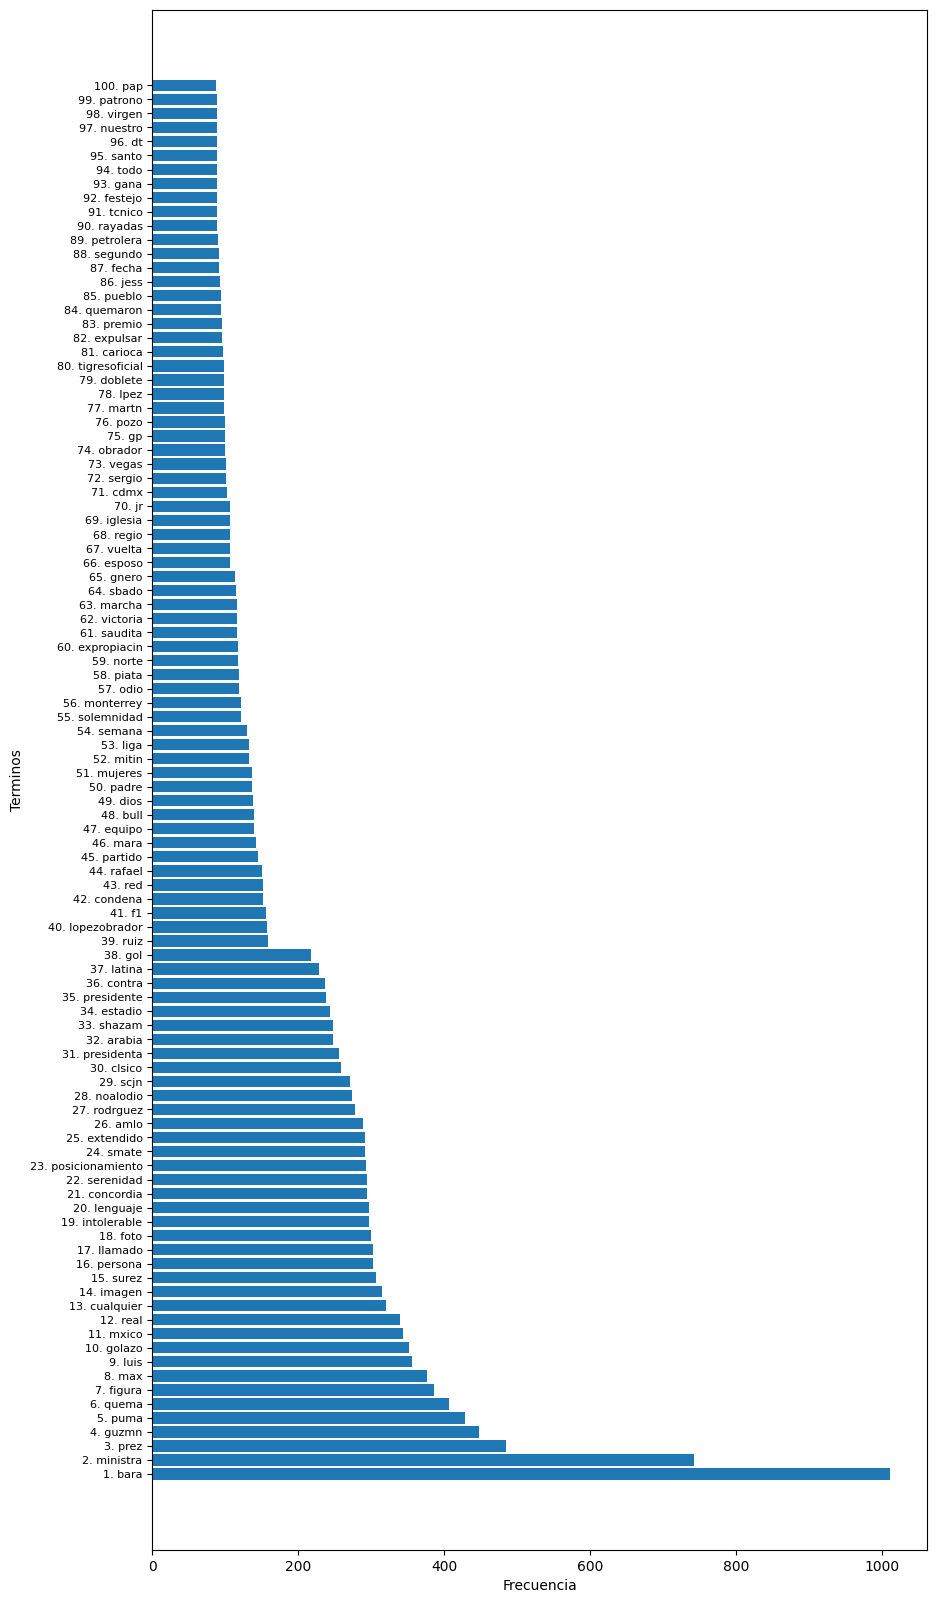

In [6]:
data=bd.get_top_100_words_by_count_w()
terms = [x[0] for x in data]
counts = [x[1] for x in data]


fig, ax = plt.subplots(figsize=(10, 20))  # Create a new figure with a larger size
ax.barh(terms, counts)  # Use horizontal bar chart
ax.set_xlabel('Frecuencia')  # Set the x-axis label
ax.set_ylabel('Terminos')  # Set the y-axis label

# Set the ticks and tick labels for the y-axis
ax.set_yticks(range(len(terms)))

ax.set_yticklabels([f'{i+1}. {term}' for i, term in enumerate(terms)])
# Rotate the tick labels for better readability
plt.setp(ax.get_yticklabels(), rotation=0, fontsize=8)


plt.show()

In [ ]:
hashtags=["AIFA","Bayern Munich","Floricienta","Himno","John Kerry","NINE OR NONE","Ohtani","QSMP","Teatro del Pueblo","Corea del Norte","ESENCIA OUT NOW","Scarlett Camberos","Humbe","Jenare","#floresamarillas","Surinam","TU VALOR","The Rock","Japón","SNIPER", "REINA", "AZUL","Shenhe","#21deMarzo","#FelizMartes","#WorldBaseballClassic","Alicia Keys","Américas","Aries","Benito Juárez","Black Adam",]
  
for hashtag in hashtags:
    analisis_t(hashtag)

In [ ]:
hashtags=["Checo","Akron","América","Chivas","Cisneros","Lara","Pocho","Rayados","Romo","Mozo","Cabecita","Vega","Tigres","Andrada","Chima","Pizarro","#ClasicoNacional","Rafa", "Puente","Pumas","Norma Piña","San José","Henry","Judas","Verstappen","Gonzalo","Barça","Leo Suárez","Violencia","Zócalo"]
for hashtag in hashtags:
    analisis_t(hashtag)

In [ ]:
hashtags1=["AIFA","Bayern Munich","Floricienta","Himno","John Kerry","NINE OR NONE","Ohtani","QSMP","Teatro del Pueblo","Corea del Norte","ESENCIA OUT NOW","Scarlett Camberos","Humbe","Jenare","#floresamarillas","Surinam","TU VALOR","The Rock","Japón","SNIPER", "REINA", "AZUL","Shenhe","#21deMarzo","#FelizMartes","#WorldBaseballClassic","Alicia Keys","Américas","Aries","Benito Juárez","Black Adam",]
hashtags2=["Checo","Akron","América","Chivas","Cisneros","Lara","Pocho","Rayados","Romo","Mozo","Cabecita","Vega","Tigres","Andrada","Chima","Pizarro","#ClasicoNacional","Rafa", "Puente","Pumas","Norma Piña","San José","Henry","Judas","Verstappen","Gonzalo","Barça","Leo Suárez","Violencia","Zócalo"]
hashtags3=[ "Pumas","#SaudiArabianGP","Acarreados","Alonso","Barça","Barcelona","Carvajal","Checo","chivas","Clasismo","Henry","Red Bull","San José","Taylor","Verstappen","Zócalo","Louis","Tomlinson","América","Kessie","Rafa Puente","Xavi","Benzema","Lara","Madrid"]  
for hashtag in hashtags:
    analisis_t(hashtag)

In [27]:
scores=bd.get_tweets_h_s_d()
df=pd.DataFrame(scores,columns=["hashtags","Score"])
df

,hashtags,Score
0,Pumas,4
1,Pumas,1
2,Pumas,1
3,Pumas,3
4,Pumas,1
...,...,...
104766,Black Adam,4
104767,Black Adam,5
104768,Black Adam,1
104769,Black Adam,4


In [8]:


df['Polaridad'] = df['Score'].apply(calcular_polaridad)


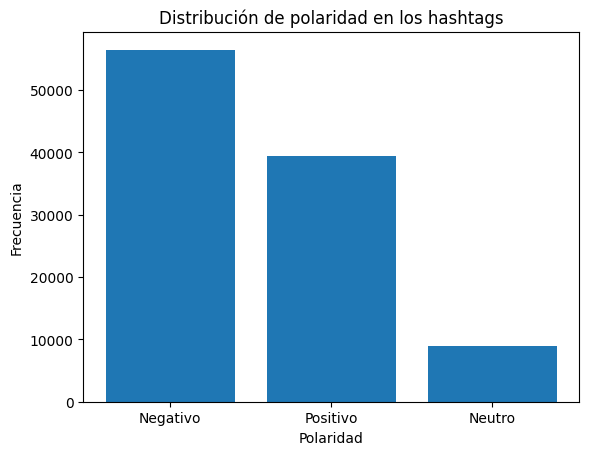

In [11]:


# Define bins for sentiment categories
bins = [0, 0.4, 0.65, 1]

# Define labels for sentiment categories
labels = ['Negativo', 'Neutro', 'Positivo']



# Contar la frecuencia de cada polaridad en los hashtags
counts = df['Polaridad'].value_counts()

# Crear el gráfico de barras
plt.bar(counts.index, counts.values)

# Configurar los ejes
plt.xlabel('Polaridad')
plt.ylabel('Frecuencia')
plt.title('Distribución de polaridad en los hashtags')

# Mostrar el gráfico
plt.show()

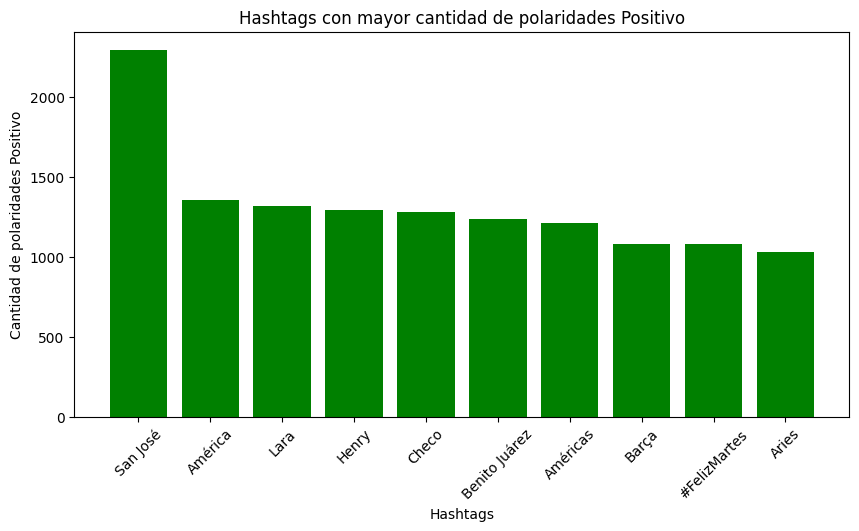

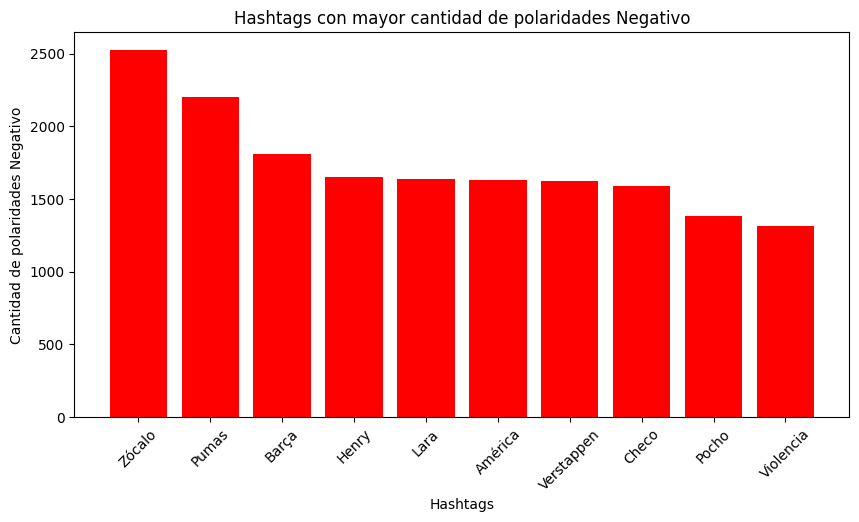

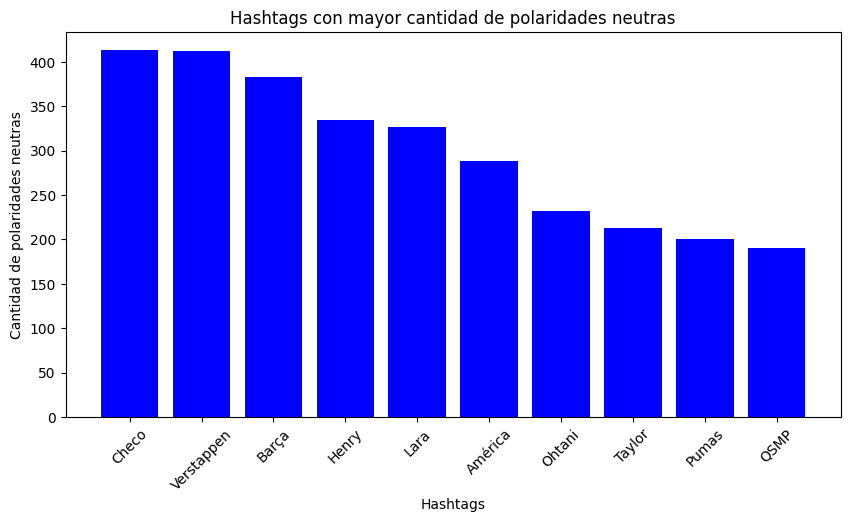

In [12]:

# Agrupar por hashtag y polaridad
counts = df.groupby(['hashtags', 'Polaridad']).size().unstack(fill_value=0)
counts.head
# Ordenar por la cantidad de polaridades positivas
counts_positivas = counts.sort_values(by=['Positivo'], ascending=False).head(10)

# Crear el gráfico de barras para las polaridades positivas
plt.figure(figsize=(10, 5))
plt.bar(counts_positivas.index, counts_positivas['Positivo'], color='green')
plt.xlabel('Hashtags')
plt.ylabel('Cantidad de polaridades Positivo')
plt.title('Hashtags con mayor cantidad de polaridades Positivo')
plt.xticks(rotation=45)
plt.show()

# Ordenar por la cantidad de polaridades negativas
counts_negativas = counts.sort_values(by=['Negativo'], ascending=False).head(10)
# Crear el gráfico de barras para las polaridades negativas
plt.figure(figsize=(10, 5))
plt.bar(counts_negativas.index, counts_negativas['Negativo'], color='red')
plt.xlabel('Hashtags')
plt.ylabel('Cantidad de polaridades Negativo')
plt.title('Hashtags con mayor cantidad de polaridades Negativo')
plt.xticks(rotation=45)
plt.show()

# Ordenar por la cantidad de polaridades neutras
counts_neutras = counts.sort_values(by=['Neutro'], ascending=False).head(10)

# Crear el gráfico de barras para las polaridades neutras
plt.figure(figsize=(10, 5))
plt.bar(counts_neutras.index, counts_neutras['Neutro'], color='blue')
plt.xlabel('Hashtags')
plt.ylabel('Cantidad de polaridades neutras')
plt.title('Hashtags con mayor cantidad de polaridades neutras')
plt.xticks(rotation=45)
plt.show()


In [25]:
hashtags = df.groupby('hashtags')['Score'].agg(['count', 'mean']).reset_index()
hashtags

,hashtags,count,mean
0,#21deMarzo,1368,3.150585
1,#ClasicoNacional,1322,2.767020
2,#FelizMartes,1611,3.722533
3,#SaudiArabianGP,700,2.962857
4,#WorldBaseballClassic,1611,3.633147
...,...,...,...
70,Verstappen,3036,2.598155
71,Violencia,1665,1.774174
72,Xavi,1611,2.819988
73,Zócalo,3276,1.841575


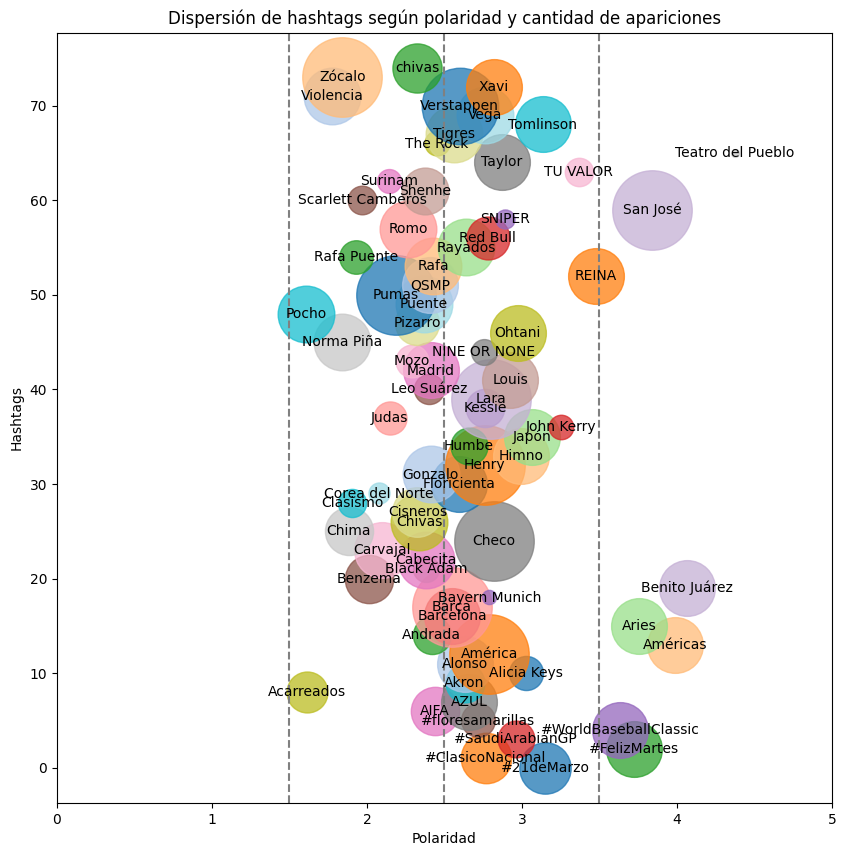

In [24]:
# Calcular la cantidad de veces que aparece cada hashtag y la polaridad promedio de cada hashtag
hashtags = df.groupby('hashtags')['Score'].agg(['count', 'mean']).reset_index()
hashtags.columns = ['hashtags', 'count', 'polaridad']

# Escala para el tamaño de los puntos
scale = 1

# Crear el gráfico de dispersión
fig, ax = plt.subplots(figsize=(10, 10))
for i, row in hashtags.iterrows():
    ax.scatter(row['polaridad'], i, s=row['count']*scale, alpha=0.75, color=colors[i])
    ax.annotate(row['hashtags'], xy=(row['polaridad'], i), ha='center', va='center')

# Configurar los ejes y el título
ax.set_xlim([0, 5])
ax.set_xlabel('Polaridad')
ax.set_ylabel('Hashtags')
ax.set_title('Dispersión de hashtags según polaridad y cantidad de apariciones')
# Agregar línea punteada para dividir el gráfico en dos cuadrantes
ax.axvline(x=2.5, linestyle='--', color='gray')
ax.axvline(x=3.5, linestyle='--', color='gray')
ax.axvline(x=1.5, linestyle='--', color='gray')


# Mostrar el gráfico
plt.show()